In [1]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR, STDP_SR, Linear, MLP
from datasets import inputs, sf_inputs_discrete
from run_td_rnn import run as run_rnn
from run_td_mlp import run as run_mlp
from run_td_linear import run as run_linear

device = 'cpu'

/home/chingf/Code/sr-project/datasets/inputs.py:12: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")
/home/chingf/Code/sr-project/datasets/sf_inputs_discrete.py:14: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")


In [172]:
dt_to_sec = 3
bin_to_cm = 5
num_steps = 4000
num_states = 30

In [210]:
# Right-biased 1D Walk
dset = inputs.Sim1DWalk(
    num_steps=num_steps, left_right_stay_prob=[1, 1, 1.5],
    num_states=num_states
    )

In [211]:
# Set up network
save_path = '../trained_models/baseline/'
model_path = save_path + 'model.pt'
net_configs_path = save_path + 'net_configs.p'
with open(net_configs_path, 'rb') as f:
    net_configs = pickle.load(f)
net_configs.pop('num_states')
net = STDP_SR(num_states=num_states, **net_configs)
net.load_state_dict(torch.load(model_path))
net.ca3.set_differentiability(False)

In [212]:
# Set up dataset
dg_inputs = torch.from_numpy(dset.dg_inputs.T).float().to(device).unsqueeze(1)
dg_modes = torch.from_numpy(dset.dg_modes.T).float().to(device).unsqueeze(1)
input_states = []
for t in range(dg_inputs.shape[0]):
    input_states.append(np.argwhere(dg_inputs[t,0])[0,0])
input_states = np.array(input_states)

In [213]:
# Get lap start indices
lap_starts = [0]
state_counts = np.zeros(num_states)
for t, input_state in enumerate(input_states):
    if not np.any(state_counts == 0):
        lap_starts.append(t)
        state_counts = np.zeros(num_states)
    state_counts[input_state] += 1
lap_starts = np.array(lap_starts)

# Run network

In [214]:
Ms = []
for step in range(dset.num_steps):
    curr_dg_input = dg_inputs[step].unsqueeze(0)
    curr_dg_mode = dg_modes[step].unsqueeze(0)
    reset = True if step == 0 else False
    _, outputs = net(curr_dg_input, curr_dg_mode, reset=reset)
    if step in lap_starts:
        Ms.append(net.get_M(0.95))

# Plot place field induction laps

In [215]:
for state in np.unique(input_states):
    first_t = np.argwhere(input_states == state)[0,0]
    print(f'State {state} first encountered in {first_t}')

State 0 first encountered in 1
State 1 first encountered in 2
State 2 first encountered in 3
State 3 first encountered in 14
State 4 first encountered in 28
State 5 first encountered in 29
State 6 first encountered in 30
State 7 first encountered in 32
State 8 first encountered in 33
State 9 first encountered in 51
State 10 first encountered in 56
State 11 first encountered in 57
State 12 first encountered in 58
State 13 first encountered in 60
State 14 first encountered in 61
State 15 first encountered in 63
State 16 first encountered in 71
State 17 first encountered in 76
State 18 first encountered in 101
State 19 first encountered in 103
State 20 first encountered in 111
State 21 first encountered in 127
State 22 first encountered in 133
State 23 first encountered in 134
State 24 first encountered in 135
State 25 first encountered in 136
State 26 first encountered in 143
State 27 first encountered in 224
State 28 first encountered in 268
State 29 first encountered in 0


In [246]:
chosen_state = 14
num_laps = 20
M_vectors = [M[chosen_state,:].detach().numpy() for M in Ms]
M_vectors = np.array(M_vectors)

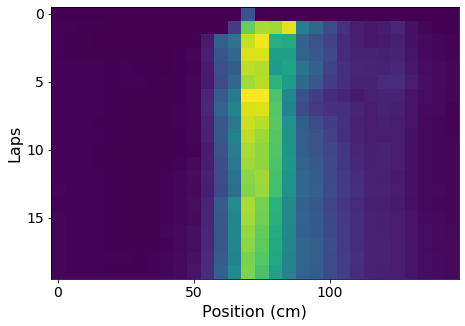

In [248]:
label_fontsize = 16
tick_fontsize = 14
plt.figure(figsize=(8,5))
plt.imshow(M_vectors[:num_laps])
plt.yticks([0, 5, 10, 15], fontsize=tick_fontsize)
plt.ylabel('Laps', fontsize=label_fontsize)
tick_locs = np.array([0, 50, 100]) # In cm
plt.xticks(tick_locs/bin_to_cm, tick_locs, fontsize=tick_fontsize)
plt.xlabel('Position (cm)', fontsize=label_fontsize)
plt.savefig('field_induction.png', dpi=200)
plt.show()